## Web scrapping for reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests

In [2]:
wm_title=[]
wm_date = []
wm_content = []
wm_rating = []

for i in range(1,150):

  link = "https://www.amazon.in/Apple-MacBook-Air-13-3-inch-MQD32HN/product-reviews/B073Q5R6VR/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&amp;amp;reviewerType=all_reviews&amp;amp;pageNumber="+str(i)
  response = requests.get(link)
  soup = bs(response.content,"html.parser")# creating soup object to iterate over the extracted content

  # extracting Review Title
  title = soup.find_all('a',class_='review-title-content')
  review_title = []
  for i in range(0,len(title)):
      review_title.append(title[i].get_text())
  review_title[:] = [titles.lstrip('\n') for titles in review_title]
  review_title[:] = [titles.rstrip('\n') for titles in review_title]
  wm_title = wm_title + review_title

  ## Extracting Ratings
  rating = soup.find_all('i',class_='review-rating')
  review_rating = []
  for i in range(2,len(rating)):
      review_rating.append(rating[i].get_text())
  #review_rating.pop(0)
  #review_rating.pop(0)
  review_rating[:] = [reviews.rstrip(' out of 5 stars') for reviews in review_rating]
  wm_rating = wm_rating + review_rating

  #Extracting Content of review
  review = soup.find_all("span",{"data-hook":"review-body"})
  review_content = []
  for i in range(0,len(review)):
      review_content.append(review[i].get_text())
  review_content[:] = [reviews.lstrip('\n') for reviews in review_content]
  review_content[:] = [reviews.rstrip('\n') for reviews in review_content]
  wm_content = wm_content + review_content

  #Extracting dates of reviews
  dates = soup.find_all('span',class_='review-date')
  review_dates = []
  for i in range(2,len(rating)):
      review_dates.append(dates[i].get_text())
  review_dates[:] = [reviews.lstrip('Reviewed in India on') for reviews in review_dates]
  #review_dates.pop(0)
  #review_dates.pop(0)
  wm_date  = wm_date + review_dates


In [3]:
print(len(wm_title))
print(len(wm_rating))
print(len(wm_content))
print(len(wm_date))

590
590
590
590


In [4]:
df = pd.DataFrame()
df['Title'] = wm_title
df['Ratings'] = wm_rating
df['Comments'] = wm_content
df['Date'] = wm_date

df.head(5)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,28 September 2017
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,15 August 2017
2,4.0 out of 5 stars\nA biased review from a per...,4.0,"Apple,apple,apple, thats the first thing that ...",30 March 2019
3,5.0 out of 5 stars\nAmazing ultrabook laptop i...,5.0,I've been a strong apple product user since 20...,25 September 2017
4,5.0 out of 5 stars\nperfect for everyday use a...,5.0,"Apple always design with perfection. No doubt,...",31 October 2017


In [5]:
df.head(2)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,28 September 2017
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,15 August 2017


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     590 non-null    object
 1   Ratings   590 non-null    object
 2   Comments  590 non-null    object
 3   Date      590 non-null    object
dtypes: object(4)
memory usage: 18.6+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Ratings'] = df['Ratings'].astype(float)
df.head(2)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,2017-09-28
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,2017-08-15


## Text Cleaning

1. lower the text
2. tokenize the text (split the text into words) and remove the punctuation
3. remove useless words that contain numbers
4. remove useless stop words like ‘the’, ‘a’ ,’this’ etc.
5. Part-Of-Speech (POS) tagging: assign a tag to every word to define 6. if it corresponds to a noun, a verb etc. using the WordNet lexical database
7. lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

In [7]:
df.head(2)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,2017-09-28
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,2017-08-15


In [8]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [9]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [10]:
# clean text data
df["Comments"] = df["Comments"].apply(lambda x: clean_text(x))

In [11]:
df['Title'] = df['Title'].astype(str)
df['Title'] = df['Title'].apply(lambda x: clean_text(x))

In [12]:
df.head(5)

,Title,Ratings,Comments,Date
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15
2,stars\na bias review person used month,4.0,"apple,apple,apple thats first thing must flash...",2019-03-30
3,stars\nvery good product,5.0,tremendous product last long time still use,2023-11-19
4,stars\namazing ultrabook laptop segment,5.0,i've strong apple product user since i've use ...,2017-09-25


## Feature Engineering

In [13]:
#  add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Comments"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
'''
sid = SentimentIntensityAnalyzer()
df["sentiments_title"] = df["Title"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments_title'], axis=1), df['sentiments_title'].apply(pd.Series)], axis=1)
'''
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970
2,stars\na bias review person used month,4.0,"apple,apple,apple thats first thing must flash...",2019-03-30,0.037,0.715,0.248,0.9969
3,stars\nvery good product,5.0,tremendous product last long time still use,2023-11-19,0.000,1.000,0.000,0.0000
4,stars\namazing ultrabook laptop segment,5.0,i've strong apple product user since i've use ...,2017-09-25,0.076,0.748,0.176,0.9607
...,...,...,...,...,...,...,...,...
85,stars\nperfect everyday use small scale profes...,5.0,apple always design perfection doubt macbook a...,2017-10-31,0.045,0.687,0.268,0.9963
86,stars\nfluid fast beautiful,5.0,first experience mac need laptop need much att...,2018-07-08,0.082,0.747,0.171,0.9382
87,stars\nproduct bad quality,1.0,doubt apple product bad suspect seller appario...,2023-10-08,0.223,0.777,0.000,-0.9393
88,year still battery good,5.0,excellent,2024-01-09,0.000,0.000,1.000,0.5719


In [14]:
# add number of characters column
df["nb_chars"] = df["Comments"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["Comments"].apply(lambda x: len(x.split(" ")))

''''
# add number of characters column
df["nb_chars_title"] = df["Title"].apply(lambda x: len(x))

# add number of words column
df["nb_words_title"] = df["Title"].apply(lambda x: len(x.split(" ")))
'''

'\'\n# add number of characters column\ndf["nb_chars_title"] = df["Title"].apply(lambda x: len(x))\n\n# add number of words column\ndf["nb_words_title"] = df["Title"].apply(lambda x: len(x.split(" ")))\n'

In [15]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Comments"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each Comment into a vector data
doc2vec_df = df["Comments"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

'''
# transform each Title into a vector data
doc2vec_df_title = df["Title"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df_title.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df_title], axis=1)
'''

'\n# transform each Title into a vector data\ndoc2vec_df_title = df["Title"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)\ndoc2vec_df_title.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]\ndf = pd.concat([df, doc2vec_df_title], axis=1)\n'

In [18]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Comments"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)
df

'''
##TF-IDF for Titles
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Title"]).toarray()
tfidf_df_title = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df_title.columns = ["word_" + str(x) for x in tfidf_df_title.columns]
tfidf_df_title.index = df.index
df = pd.concat([df, tfidf_df_title], axis=1)
'''

'\n##TF-IDF for Titles\ntfidf = TfidfVectorizer(min_df = 10)\ntfidf_result = tfidf.fit_transform(df["Title"]).toarray()\ntfidf_df_title = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())\ntfidf_df_title.columns = ["word_" + str(x) for x in tfidf_df_title.columns]\ntfidf_df_title.index = df.index\ndf = pd.concat([df, tfidf_df_title], axis=1)\n'

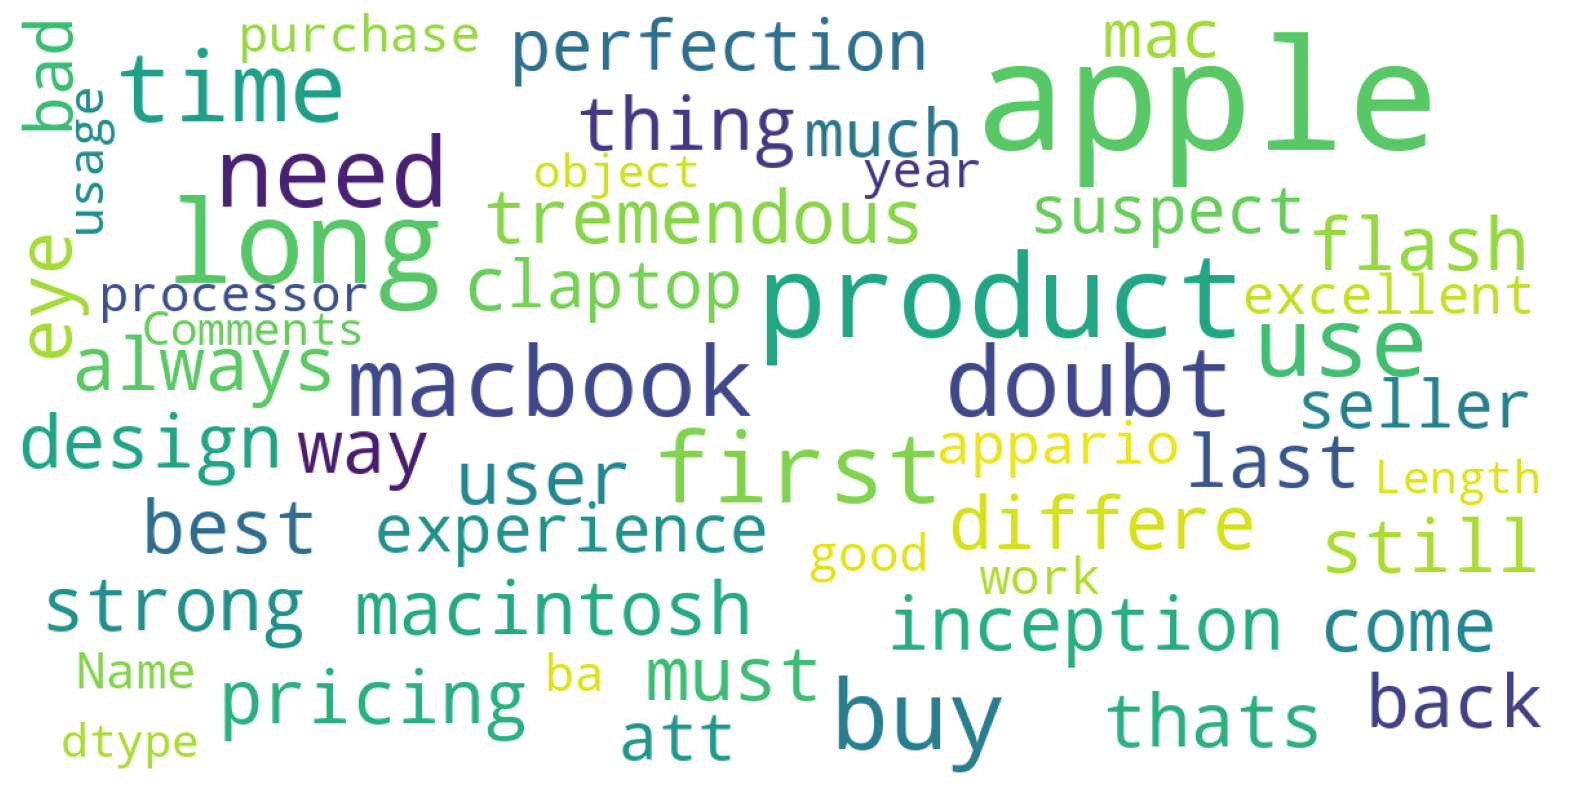

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(df["Comments"])

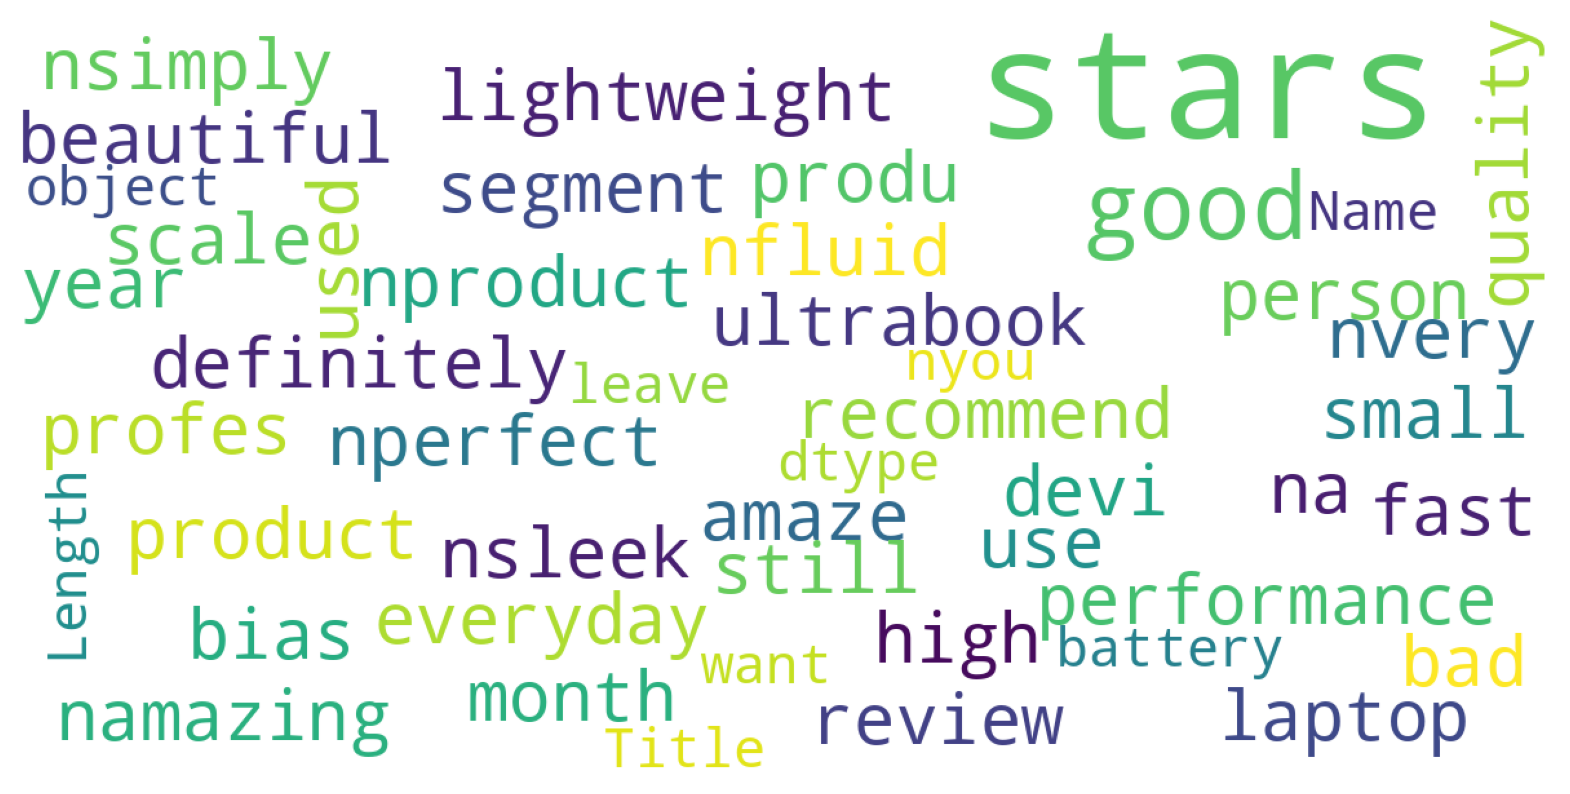

In [20]:
# print wordcloud
show_wordcloud(df["Title"])

In [21]:
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_version,word_video,word_want,word_way,word_well,word_windows,word_work,word_would,word_year,word_yes
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984,2720,391,...,0.107848,0.0,0.0,0.045776,0.079840,0.000000,0.0,0.0,0.0,0.0
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970,1626,251,...,0.057758,0.0,0.0,0.000000,0.085517,0.042758,0.0,0.0,0.0,0.0


In [22]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Comments", "pos"]].head(10)

,Comments,pos
41,eye macbook long time pricing best buy differe...,0.288
1,eye macbook long time pricing best buy differe...,0.288
21,eye macbook long time pricing best buy differe...,0.288
61,eye macbook long time pricing best buy differe...,0.288
81,eye macbook long time pricing best buy differe...,0.288
71,eye macbook long time pricing best buy differe...,0.288
51,eye macbook long time pricing best buy differe...,0.288
11,eye macbook long time pricing best buy differe...,0.288
31,eye macbook long time pricing best buy differe...,0.288
45,apple always design perfection doubt macbook a...,0.268


In [ ]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Comments", "neg"]].head(10)

,Comments,neg
283,often find traumatic problem machine ridiculou...,0.560
201,product broken deliver need cancel product,0.560
388,quality inferior day stop work today suddenly,0.495
166,waste money small advise buyer go money waste,0.483
454,receive damage product first time replacement ...,0.466
189,back panel open loose screw also wash machine ...,0.463
1084,expect poor quality it’s defective product it’...,0.462
5,worst product.the product receive broken botto...,0.444
280,broken piece know time use,0.437
141,bad product receive damaged product amazon bad...,0.432


In [ ]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_well,word_wheel,word_whirlpool,word_within,word_work,word_working,word_worth,word_would,Month,Year
0,get broken product,1.0,get broken product wheel broken please replace...,2018-11-05,0.354,0.514,0.131,-0.5994,76,12,...,0.0,0.474499,0.000000,0.0,0.0,0.0,0.0,0.0,11,2018
1,two separate water inject wash rinse,1.0,two separate water inject wash rinse cumbersom...,2018-09-01,0.000,1.000,0.000,0.0000,89,14,...,0.0,0.000000,0.387807,0.0,0.0,0.0,0.0,0.0,9,2018


In [ ]:
df_recent = df[(df['Year']== 2020) & (df['Month'] != 8)]
df_recent.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_well,word_wheel,word_whirlpool,word_within,word_work,word_working,word_worth,word_would,Month,Year
6,use product deliver,2.0,minus star product deliver detergent stain was...,2020-01-06,0.094,0.784,0.123,0.1779,318,51,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1,2020
10,buy want waste money,1.0,useless piece junk last godrej wash machine us...,2020-06-06,0.266,0.671,0.063,-0.8519,261,40,...,0.0,0.0,0.139285,0.203215,0.0,0.0,0.0,0.0,6,2020
